In [60]:
import numpy as np
import pandas as pd
import math
from multiclass_logistic_regression import LogisticRegression as lg
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, HTML
import seaborn as sns

from pandas.plotting import scatter_matrix
from pandas.plotting import parallel_coordinates

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve

from sklearn.decomposition import PCA as sklearnPCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.datasets.samples_generator import make_blobs

# Modelo de Regressão logística para classificar variações de flores da espécie Íris

### Introdução

O objetivo deste trabalho é construir um modelo para classificação de flores da espécie Íris, usando um conjunto de dados coletados no trabalho do estatístico e biólogo **RONALD FISHER (1936)** em seu paper ***The use of multiple measurements in taxonomic problems***. RONALD (et al) quantificou a variação morfológica de flores de íris de três espécies relacionadas - Iris setosa, Iris versicolor e Iris virginica. Duas das três espécies foram coletadas na Península de Gaspé no mesmo campo, colhidas no mesmo dia e medidas ao mesmo tempo pela mesma pessoa com o mesmo aparelho.


Mais informações: https://en.wikipedia.org/wiki/Iris_flower_data_set

Abaixo, é possível ver a tabela de dados utilizada e gráficos de correlação entre as variáveis numéricas do tamanho das pétalas e sépalas.

In [61]:
iris = sns.load_dataset("iris")
iris['species'] = np.where(iris['species'] == 'setosa', 1, 0)
HTML(iris.to_html())

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
5,5.4,3.9,1.7,0.4,1
6,4.6,3.4,1.4,0.3,1
7,5.0,3.4,1.5,0.2,1
8,4.4,2.9,1.4,0.2,1
9,4.9,3.1,1.5,0.1,1


Para este pequeno estudo, construímos um modelo capaz de prever se determinada flor é da espécie setosa ou não. Não foram consideradas outras espécies, o modelo apenas classifica como **setosa** ou **não setosa**. A classe alvo foi modificada e as setosas são identificadas com 1 e não setosas como 0.

Em uma distribuição simples de todos os pontos, dá para ver mais ou menos a distribuição de cada uma das variáveis. Embora seja difícil a visualização a olho nu, tentaremos usar estas variáveis para descobrir qual a espécie da flor avaliada.

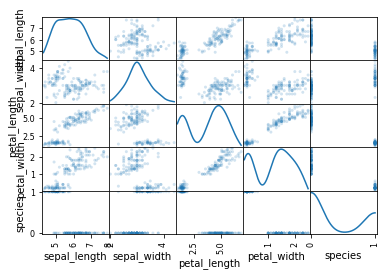

In [62]:
scatter_matrix(iris, alpha=0.2, diagonal='kde')
plt.show()

O conjunto de dados contém 150 exemplares com 50 da classe das setosas e 100 de outras espécies (Iris versicolor e Iris virginica). As plantas foram classificadas conforme a largura e altura de suas pétalas e de suas sépalas (https://pt.wikipedia.org/wiki/S%C3%A9pala). Todas as informações estão na unidade de centímetros.

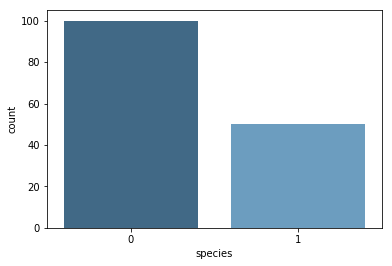

In [63]:
sns.countplot(x="species", data=iris, palette="Blues_d")
plt.show()

A altura e largura das pétalas e sépalas indicam o tipo de espécie de íris. Conforme a fiura abaixo, a distribuição dos valores indicam discrepâncias entre as variáveis. Porém todas elas são valores reais na unidade centímetro. A única variável que não é real é a variável alvo que indica a espécie da flor.

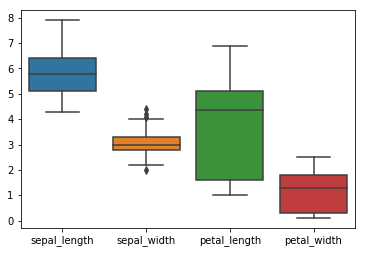

In [64]:
data = iris.loc[:, ~iris.columns.str.contains("species")]
sns.boxplot(data=data);
plt.show()

Os dados estão bem organizados, na mesma unidade, não possuem valores nulos e nem faltando. Por isso nenhuma modificação foi feita nos dados.

# 1.Implementando o algoritmo de regressão logística

O algoritmo de regressão logística encontrou um conjunto de coeficientes. Intuitivamente, essa função separa os pontos de dados em duas regiões, onde uma região corresponde aos pontos classificados como **setosa**, a outra região contém os pontos que representam as outras espécies de íris.

In [65]:
H = data
H.insert(loc=0, column='W0', value=1)
y_serie = pd.Series(iris.species)

data_X_train, data_X_test, data_Y_train, data_Y_test = train_test_split(H, y_serie, test_size=0.3, random_state=42)
#hiperparameters
alpha = 0.001

logisticRegression = lg(alpha, 'setosa', 0.5, 1)
logisticRegression.fit(data_X_train, pd.DataFrame(data_Y_train))

In [66]:
coef = ['W0', 'W1', 'W2', 'W3', 'W4']
df = pd.DataFrame(logisticRegression.coef_)
df.insert(loc=0, column='coefficients', value=coef)
df

,coefficients,0
0,W0,0.320360
1,W1,0.502653
2,W2,1.754259
3,W3,-2.751582
4,W4,-1.221462


Os coeficientes encontrados foram baixos, o que indica um baixo overffiting.

In [67]:
predictions = np.c_[logisticRegression.predict(data_X_test), data_Y_test]
pd.DataFrame(confusion_matrix(predictions[:, 0], predictions[:, 1]))

,0,1
0,26,0
1,0,19


Pela matriz de confusão é possível retirar várias métricas, que são encontradas na figura abaixo. O algoritmo gerou um bom modelo, capaz de prever com 100% de precisão as espécies de setosa **(verdadeiros positivos)** do conjunto de teste. O modelo támbém foi bom na identificação de flores que não são setosas **(verdadeiros negativos)**.

In [68]:
logisticRegression.metrics(predictions[:, 0], predictions[:, 1])

,metrics,values
0,false_p,0
1,f-measure,0
2,total_of_points,45
3,recall,1
4,true_n,26
5,precision,1
6,true_p,19
7,error,0
8,false_n,0
9,accuracy,1


## ScikitLearn

O algoritmo de regressão logística do Scikitlearn gerou um modelo tão bom quanto o nosso. Ele acertou todos os verdadeiros positivos e também os verdadeiros negativos. Os coeficientes encontrados foram ligeiramente diferentes, mas ambos foram capazes de prever corretamente todas as instâncias do conjunto de teste.

In [69]:
logreg = linear_model.LogisticRegression()
model = logreg.fit(data_X_train, data_Y_train)
values = list(model.coef_[0])
df['scikit_params'] = values
df

,coefficients,0,scikit_params
0,W0,0.320360,0.226862
1,W1,0.502653,0.335079
2,W2,1.754259,1.335169
3,W3,-2.751582,-2.096453
4,W4,-1.221462,-0.919477


In [70]:
result = np.c_[model.predict(data_X_test), data_Y_test]
pd.DataFrame(confusion_matrix(result[:, 0], result[:, 1]))

,0,1
0,26,0
1,0,19


## Conclusão

O modelo gerado tem um poder muito semelhantes ao gerado pelo Scikitlearn. Os algoritmos são diferentes, pois a aimplementação do ScikitLearn é bem mais sofisticada in clusive em termos de tunar parâmetros para descobrir o melhor tradeoff entre bias e variância. Porém, a previsão no conjunto de testes foi muito boa do nosso modelo, tãoboa quanto a do ScikitLearn. Precisariamos de mais dados para verificar se o modelo é capaz de prever melhor dados desconhecidos.